In [39]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
import sklearn.cluster
import sklearn.linear_model
from sklearn import datasets, linear_model
from sklearn.svm import SVR
%matplotlib inline

In [40]:
#specify data source 
datasource = 'L'

In [41]:
zipcode = '92562'
#zipcode = '08641'

In [42]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [43]:
data = pd.read_csv(dataDir +'/training_data_fitted_adjusted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [44]:
weatherdatasource = '/data/weather/weathersource/hourly/'
if (zipcode == '08641')|(zipcode =='08640'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'08641_20132014.csv')
if (zipcode == '92562')|(zipcode =='92563'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'92563_20132014.csv')

weatherdata['tsLocal'] = weatherdata.timestamp.map(lambda x: x[0:10] + " " + x[11:19])
#weatherdata.tsLocal = weatherdata.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
if type(weatherdata.tsLocal[0])==str:
    weatherdata['tsLocal'] = weatherdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
weatherdata.drop(['timestamp','country','postal_code'], axis=1, inplace=True)

In [45]:
if weatherdata.shape[0]!=len(set(weatherdata['tsLocal'])):
    for i in range(weatherdata.shape[0]):
        if weatherdata.loc[i,'tsLocal'] == weatherdata.loc[(i+1),'tsLocal']:
            print weatherdata.loc[i,'tsLocal']

In [46]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,5.120855


In [47]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.177334,0.467511,0.568511,0.710033,0.746246,0.75671,0.714601,0.677578,0.527082,0.429756,0.149853


In [48]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:00:00,0.772319,-298.174761,NaN,2,13.528266,-0.999883,-355,0.264652,NaN,0.706748


# Basic time series construction with hourly volatility

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [49]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
        
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,weatherdata,on=['tsLocal'], how = 'left') 



In [50]:
d.shape

(70080, 12)

In [51]:
for j in range(1,12):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
        #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [52]:
#Now we can merge our backbone + weather with solar data
d = pd.merge(d,data,on=['tsLocal'], how = 'left') 

In [53]:
#timeseries of previous timestamps
d['power-1'] = float('NaN')
d['mpower-1'] = float('NaN')
d['mpower-2'] = float('NaN')
d['mpower-3'] = float('NaN')
d['mpower-4'] = float('NaN')
d['power-2'] = float('NaN')
d['power-3'] = float('NaN')
d['power-4'] = float('NaN')
d['power-5'] = float('NaN')
d['power-6'] = float('NaN')
d['power_y-0'] = float('NaN')
d['power_y-1'] = float('NaN')
d['power_y-2'] = float('NaN')
d['r-1'] = float('NaN')
d['r-2'] = float('NaN')
d['r-3'] = float('NaN')
d['r-4'] = float('NaN')
d['r-5'] = float('NaN')
d['r-6'] = float('NaN')
d['r_y-0'] = float('NaN')
d['r_y-1'] = float('NaN')
d['r_y-2'] = float('NaN')
d.loc[1:d.shape[0],'r-1'] = list(d['r'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'r-2'] = list(d['r'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'r-3'] = list(d['r'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'r-4'] = list(d['r'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'r-5'] = list(d['r'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'r-6'] = list(d['r'].iloc[0:(d.shape[0]-6)])
d.loc[1:d.shape[0],'mpower-1'] = list(d['mpower'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'mpower-2'] = list(d['mpower'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'mpower-3'] = list(d['mpower'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'mpower-4'] = list(d['mpower'].iloc[0:(d.shape[0]-4)])
d.loc[1:d.shape[0],'power-1'] = list(d['power'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'power-2'] = list(d['power'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'power-3'] = list(d['power'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'power-4'] = list(d['power'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'power-5'] = list(d['power'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'power-6'] = list(d['power'].iloc[0:(d.shape[0]-6)])

#24 hour shift = 24*4 shift in index. 'y' means yesterday
d.loc[96:d.shape[0],'r_y-0'] = list(d['r'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-1'] = list(d['r-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-2'] = list(d['r-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-3'] = list(d['r-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-4'] = list(d['r-4'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-0'] = list(d['power'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-1'] = list(d['power-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-2'] = list(d['power-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-3'] = list(d['power-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-4'] = list(d['power-4'].iloc[0:(d.shape[0]-96)])

In [54]:
d['cldCvr-1'] = float('NaN')
d['dewPt-1'] = float('NaN')
d['feelsLike-1'] = float('NaN')
d['precip-1'] = float('NaN')
d['relHum-1'] = float('NaN')
d['sfcPres-1'] = float('NaN')
d['snowfall-1'] = float('NaN')
d['spcHum-1'] = float('NaN')
d['temp-1'] = float('NaN')
d['windSpd-1'] = float('NaN')
d['wetBulb-1'] = float('NaN')
d.loc[1:d.shape[0],'cldCvr-1'] = list(d['cldCvr'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'dewPt-1'] = list(d['dewPt'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'feelsLike-1'] = list(d['feelsLike'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'precip-1'] = list(d['precip'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'relHum-1'] = list(d['relHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'sfcPres-1'] = list(d['sfcPres'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'snowfall-1'] = list(d['snowfall'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'spcHum-1'] = list(d['spcHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'temp-1'] = list(d['temp'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'windSpd-1'] = list(d['windSpd'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'wetBulb-1'] = list(d['wetBulb'].iloc[0:(d.shape[0]-1)])

In [55]:
#normalize weather value
d['cldCvr-1'] = (d['cldCvr-1']-np.min(d['cldCvr-1']))/(np.max(d['cldCvr-1'])-np.min(d['cldCvr-1']))
d['dewPt-1'] = (d['dewPt-1']-np.min(d['dewPt-1']))/(np.max(d['dewPt-1'])-np.min(d['dewPt-1']))
d['feelsLike-1'] = (d['feelsLike-1']-np.min(d['feelsLike-1']))/(np.max(d['feelsLike-1'])-np.min(d['feelsLike-1']))
d['precip-1'] = (d['precip-1']-np.min(d['precip-1']))/(np.max(d['precip-1'])-np.min(d['precip-1']))
d['relHum-1'] = (d['relHum-1']-np.min(d['relHum-1']))/(np.max(d['relHum-1'])-np.min(d['relHum-1']))
d['sfcPres-1'] = (d['sfcPres-1']-np.min(d['sfcPres-1']))/(np.max(d['sfcPres-1'])-np.min(d['sfcPres-1']))
d['snowfall-1'] = (d['snowfall-1']-np.min(d['snowfall-1']))/(np.max(d['snowfall-1'])-np.min(d['snowfall-1']))
d['spcHum-1'] = (d['spcHum-1']-np.min(d['spcHum-1']))/(np.max(d['spcHum-1'])-np.min(d['spcHum-1']))
d['temp-1'] = (d['temp-1']-np.min(d['temp-1']))/(np.max(d['temp-1'])-np.min(d['temp-1']))
d['windSpd-1'] = (d['windSpd-1']-np.min(d['windSpd-1']))/(np.max(d['windSpd-1'])-np.min(d['windSpd-1']))
d['wetBulb-1'] = (d['wetBulb-1']-np.min(d['wetBulb-1']))/(np.max(d['wetBulb-1'])-np.min(d['wetBulb-1']))


Let's compute rolling hourly volaitility (this is for 15 min interval)

In [56]:
#volatility derivative-based and persistence-based
#d['V-d'] = np.absolute(d['power-1']-4*d['power-2']+6*d['power-3']-4*d['power-4']+d['power-5'])
d['V-s'] = np.absolute(d['power-1']-d['power-2']/d['mpower-2']*d['mpower-1'])+\
            np.absolute(d['power-2']-d['power-3']/d['mpower-3']*d['mpower-2'])+\
             np.absolute(d['power-3']-d['power-4']/d['mpower-4']*d['mpower-3'])

Here we separate data for training and testing. Need this for autoregressive model.

In [57]:
Data = d
#select data for training and test
StartDate = datetime.date(2014,10,1)
TrainData = d[d.tsLocal.map(lambda x: x.date()) <StartDate].set_index('tsLocal')
TrainDateList = list(dsummary.Date[dsummary.Date<StartDate])
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')

#Extra screening by high energy days
HighEnergyDayList = list(dsummary.Date[dsummary.E/dsummary.mE>0.9]) #for NJ
HighEnergyTestData = d[d.tsLocal.map(lambda x: (x.date()>=StartDate) & (x.date() in HighEnergyDayList))].set_index('tsLocal')

#15-minute rolling prediction

Before doing any model, make a consistent train/test by randomly assign 80/20

In [58]:
d = Data
#Truly random
#l = np.random.permutation(d.shape[0])
#d = d.iloc[l].reset_index(drop=True)
#offset = int(d.shape[0] * 0.8)

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data_train = d[:offset]
Data_test = d[offset:]

In [59]:
Data.shape

(70080, 60)

In [60]:
#For bin reference
numbins = int(math.ceil(np.max(d['V-s'])/0.1))
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
middlebinvalue = [0.1*i+0.05 for i in range(0,numbins)]

In [61]:
#best predictors set for CA and NJ are different
if zipcode == '92562':
    feature_names = ['r-1']
    feature_names = feature_names + ['s','DBW']
    feature_names = feature_names + ['V-s']
if zipcode == '08641':
    feature_names = ['r-1']
    feature_names = feature_names + ['s','DBW']
    feature_names = feature_names + ['V-s']
    feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

## Model Reference: Zeroth

In [62]:
d_train = Data_train
d_test = Data_test
#feature_names = ['r-1']
d_train = d_train.loc[:,['tsLocal','power','mpower','r','expectedr']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r','expectedr']+feature_names].dropna()
#X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
#X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [63]:
d_test['power_predict'] = d_test['expectedr']*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_zeroth,max_zeroth] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [64]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))

maxdifflist_zeroth = maxdifflist
meandifflist_zeroth = meandifflist

In [65]:
[mean_zeroth,max_zeroth]

[0.082028677558630247, 0.46361395266524463]

## Model Reference: Persistence

In [66]:
d_train = Data_train
d_test = Data_test
#feature_names = ['r-1']
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [67]:
d_test['power_predict'] = d_test['r-1']*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_persistent,max_persistent] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [68]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))

maxdifflist_persistent = maxdifflist
meandifflist_persistent = meandifflist

In [69]:
[mean_persistent,max_persistent]

[0.018015805774362466, 0.31528279541220694]

## Complex model: GBR

In [70]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)


In [71]:
predictlist = []
DateOfInterest = StartDate 

while DateOfInterest < EndScopeTime.date():
    
    print(DateOfInterest)
    
    d_imm = Data.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()<DateOfInterest)]
    X_train, y_train = d.loc[:,feature_names], d.loc[:,'r']
    d = d_imm[d_imm['tsLocal'].map(lambda x: x.date()==DateOfInterest)]
    X_test, y_test = d.loc[:,feature_names], d.loc[:,'r']
    
    clf.fit(X_train, y_train)

    d['power_predict'] = (clf.predict(X_test))*d.loc[:,'mpower']
    d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
    d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)
    l = d.loc[:,'power']-d.loc[:,'power_predict']
    predictlist = predictlist + list(l)
        
    DateOfInterest = DateOfInterest + datetime.timedelta(days=1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2014-10-01
2014-10-02
2014-10-03
2014-10-04
2014-10-05
2014-10-06
2014-10-07
2014-10-08
2014-10-09
2014-10-10
2014-10-11
2014-10-12
2014-10-13
2014-10-14
2014-10-15
2014-10-16
2014-10-17
2014-10-18
2014-10-19
2014-10-20
2014-10-21
2014-10-22
2014-10-23
2014-10-24
2014-10-25
2014-10-26
2014-10-27
2014-10-28
2014-10-29
2014-10-30
2014-10-31
2014-11-01
2014-11-02
2014-11-03
2014-11-04
2014-11-05
2014-11-06
2014-11-07
2014-11-08
2014-11-09
2014-11-10
2014-11-11
2014-11-12
2014-11-13
2014-11-14
2014-11-15
2014-11-16
2014-11-17
2014-11-18
2014-11-19
2014-11-20
2014-11-21
2014-11-22
2014-11-23
2014-11-24
2014-11-25
2014-11-26
2014-11-27
2014-11-28
2014-11-29
2014-11-30
2014-12-01
2014-12-02
2014-12-03
2014-12-04
2014-12-05
2014-12-06
2014-12-07
2014-12-08
2014-12-09
2014-12-10
2014-12-11
2014-12-12
2014-12-13
2014-12-14
2014-12-15
2014-12-16
2014-12-17
2014-12-18
2014-12-19
2014-12-20
2014-12-21
2014-12-22
2014-12-23
2014-12-24
2014-12-25
2014-12-26
2014-12-27
2014-12-28
2014-12-29
2014-12-30

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
[mean_GBR,max_GBR] = [np.mean(np.absolute(predictlist)),np.max(np.absolute(predictlist))]

d=d_test
d['predictdiff'] = predictlist
d['power_predict'] = d['power']-d['predictdiff']
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_GBR = maxdifflist
meandifflist_GBR = meandifflist

In [73]:
[mean_GBR,max_GBR]

[0.016891443316881229, 0.30085287075277289]

In [74]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

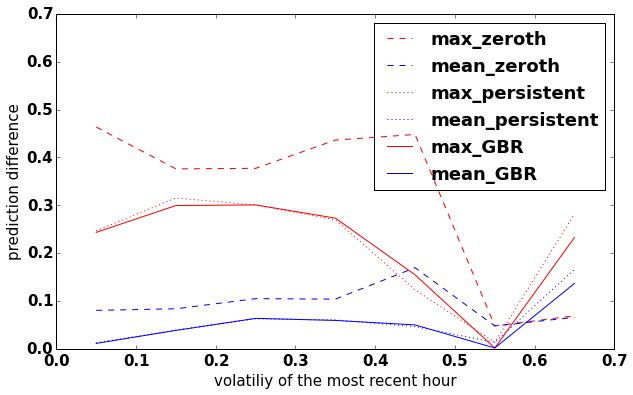

In [75]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist_zeroth,color='red',label='max_zeroth',linestyle='--')
ax1.plot(middlebinvalue,meandifflist_zeroth,color='blue',label = 'mean_zeroth',linestyle='--')
ax1.plot(middlebinvalue,maxdifflist_persistent,color='red',label='max_persistent',linestyle=':')
ax1.plot(middlebinvalue,meandifflist_persistent,color='blue',label = 'mean_persistent',linestyle=':')
ax1.plot(middlebinvalue,maxdifflist_GBR,color='red',label='max_GBR')
ax1.plot(middlebinvalue,meandifflist_GBR,color='blue',label = 'mean_GBR')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

In [76]:
[mean_zeroth,max_zeroth,mean_persistent,max_persistent,mean_GBR,max_GBR]

[0.082028677558630247,
 0.46361395266524463,
 0.018015805774362466,
 0.31528279541220694,
 0.016891443316881229,
 0.30085287075277289]